In [1]:
import warnings
import sys
sys.path.insert(0, '../../src')
warnings.filterwarnings('ignore')

import ABC_train_test3
import network
import dataset
import sanityChecks
import torch 
import scrapbook as sb
from statistics import mean 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error
import numpy as np
import pandas as pd 

In [2]:
# Read the dataset 
df = pd.read_csv('quadratic_dynamic_variance_dataset.csv')
df = df.iloc[: , 1:]
df.head()

,X0,X1,X2,X3,X4,Y
0,0.315304,0.987011,0.218901,0.794746,0.109435,28.655630
1,0.631239,0.197705,0.796847,0.201099,0.726132,40.018183
2,0.697501,0.570345,0.656077,0.511616,0.738524,44.313752
3,0.470572,0.027676,0.031520,0.439152,0.289870,11.845246
4,0.458924,0.433668,0.038507,0.899776,0.919173,25.458610


In [3]:
# Data Pre-processing 
scaler = preprocessing.StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
print(df.head())

# Get X and Y
n_features = 5
X = df.iloc[:,0:n_features]
Y = df.iloc[:,n_features]

#Add Constant 
X = X.to_numpy()
Y = Y.to_numpy()

         X0        X1        X2        X3        X4         Y
0 -0.709296  1.598717 -0.934290  0.907007 -1.211746 -0.488825
1  0.416864 -1.166663  0.991682 -1.170655  0.745600  0.378350
2  0.653058  0.138906  0.522574 -0.083900  0.784931  0.706182
3 -0.155838 -1.762368 -1.558729 -0.337511 -0.639060 -1.771772
4 -0.197360 -0.339953 -1.535443  1.274594  1.358298 -0.732818


In [4]:
#Train test split for dataset 
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2)
train_data = dataset.CustomDataset(X_train,Y_train)
test_data = dataset.CustomDataset(X_test,Y_test)

In [5]:
# Training Parameters 
n_epochs = 1000
batch_size = 32 
#Select the device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# Fit the prior model and pre - generator 
variance = np.square(X[:,1]) + 2 * abs(X[:,2]) # Dynamic Variance

# Misspecified Prior Model
y_pred = ABC_train_test3.linear_model(X)
mae = mean_absolute_error(y_pred,Y)
sb.glue("Prior Model MAE",mae)
print("Prior Model MAE", mae)

# Pre-generator Model 
y_pred = ABC_train_test3.linear_model(X)
y_pred = y_pred + np.random.normal(0,variance)
mae = mean_absolute_error(y_pred,Y)
sb.glue("Pre-generator MAE", mae)
print("Pre-generator MAE", mae)


Prior Model MAE 12.901358048739983


Pre-generator MAE 13.581764531349796


##  mGAN 

In [7]:
gen = network.Generator(n_features+1).to(device)
disc = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen.parameters(), lr=0.001, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr=0.001, betas=(0.5, 0.999))

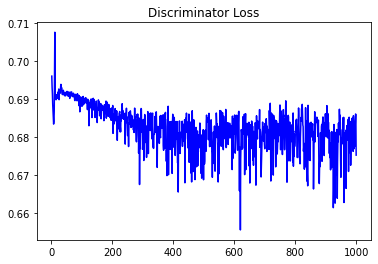

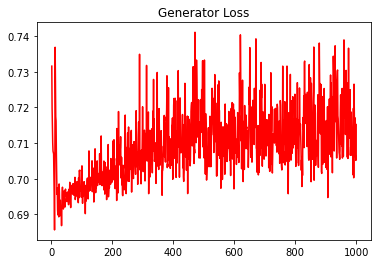

In [8]:
#Training the ABC_GAN 
ABC_train_test3.training_GAN(disc,gen,disc_opt,gen_opt,train_data,batch_size,n_epochs,criterion,ABC_train_test3.linear_model,variance,device)

In [9]:
ABC_GAN1_metrics=ABC_train_test3.test_generator(gen,test_data,ABC_train_test3.linear_model,variance,"1",device)
sb.glue("ABC_GAN_1 Metrics",ABC_GAN1_metrics)

print("MAE")
print(mean(ABC_GAN1_metrics[1]))

MAE
0.12980367178469895


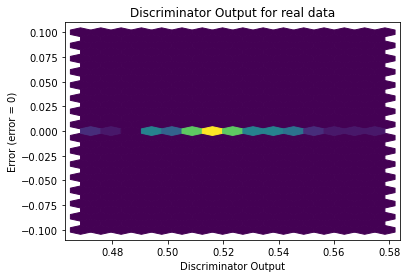

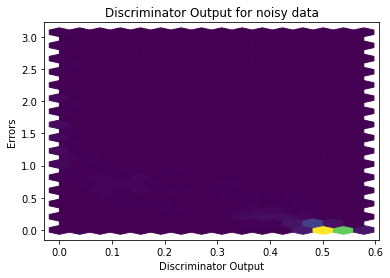

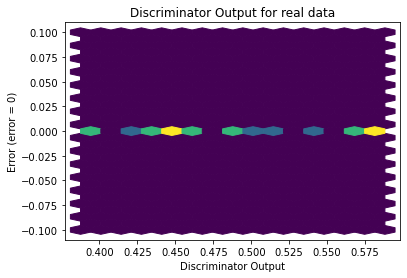

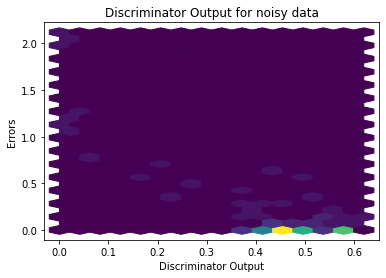

In [10]:
sanityChecks.discProbVsError(train_data,disc,device)
sanityChecks.discProbVsError(test_data,disc,device)

# ABC - GAN Model with skip connection

In [11]:
#Generator
gen3 = network.GeneratorWithSkipConnection(n_features+1).to(device)
constraints=network.weightConstraint()
#Discriminator 
disc3 = network.Discriminator(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen3.parameters(), lr=0.001, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc3.parameters(), lr=0.001, betas=(0.5, 0.999))


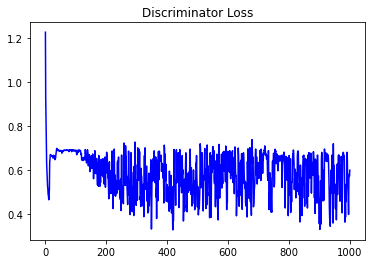

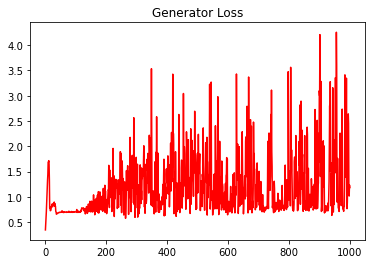

In [12]:
ABC_train_test3.training_GAN_skip_connection(disc3,gen3,disc_opt,gen_opt,train_data,batch_size,n_epochs,criterion,ABC_train_test3.linear_model,variance,device)

In [13]:
ABC_GAN3_metrics=ABC_train_test3.test_generator(gen3,test_data,ABC_train_test3.linear_model,variance,"3",device)
sb.glue("ABC_GAN_3 Metrics",ABC_GAN3_metrics)

print("MAE")
print(mean(ABC_GAN3_metrics[1]))

MAE
0.1458301233947277


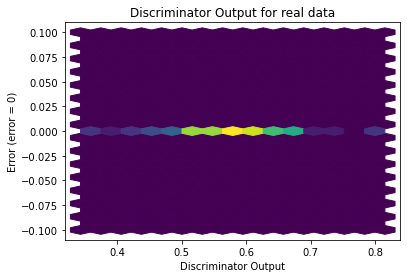

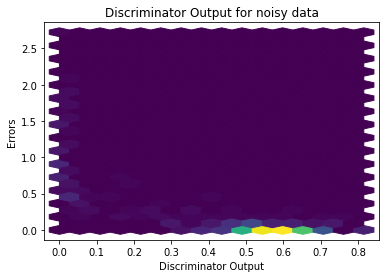

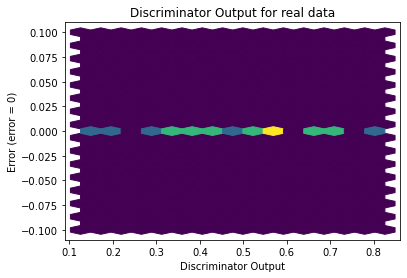

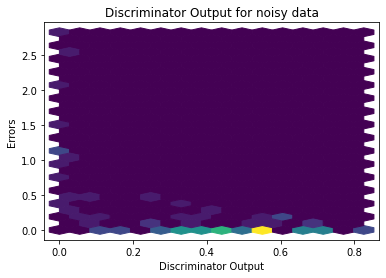

In [14]:
sanityChecks.discProbVsError(train_data,disc3,device)
sanityChecks.discProbVsError(test_data,disc3,device)

## Skip Connection Model Analysis - ABC-GAN 

### Weight Analysis 

Study the weights of the skip connection layer

Equation of the skip connection is 

$output = y_{gan} * w + y_{abc} * (1-w)$

In [15]:
print("Weight of the node at skip connection")
for name,param in gen3.named_parameters():
    if(name == "skipNode.weight"):
        print(param)
        sb.glue("Skip Connection Weight",param.item())

Weight of the node at skip connection
Parameter containing:
tensor([[0.0880]], requires_grad=True)
